In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
%matplotlib inline

In [2]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'
electron_input = '../../cta_rta_analysis/build/electrons_test.hdf5'
t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)


electrons = fact.io.read_data(electron_input, key='array_events', columns=columns)
electrons = electrons.dropna()
electrons['type'] = 2
electron_runs = fact.io.read_data(electron_input, key='runs')
mc_production_electron = MCSpectrum.from_cta_runs(electron_runs)


crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()
cosmic_electron = CTAElectronSpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
electrons['weight'] = mc_production_electron.reweigh_to_other_spectrum(cosmic_electron, electrons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

In [3]:
mc_production_proton

E_Min:0.004000000189989805 TeV, E_Max:600.0 TeV, N_total:6252000000, index:-2.0, normalization contant:9.26590010497028 1 / (m2 s sr TeV)

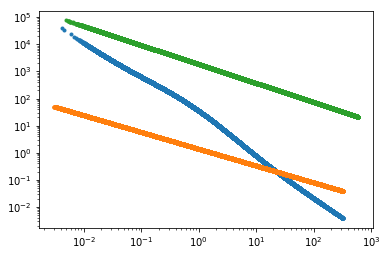

In [4]:
plt.plot(electrons.mc_energy, electrons.weight, '.')
plt.plot(gammas.mc_energy, gammas.weight, '.')
plt.plot(protons.mc_energy, protons.weight, '.')
plt.yscale('log')
plt.xscale('log')

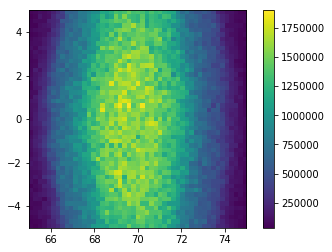

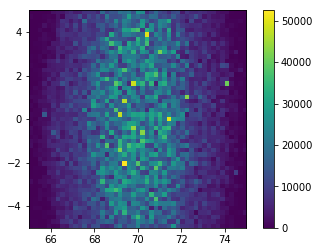

In [5]:
def plot_skymap(df):
    az_prediction = df.az_prediction.values * u.rad

    az_prediction = Angle(az_prediction).wrap_at(180*u.deg).deg
    alt_prediction = Angle(df.alt_prediction.values * u.rad).deg
    plt.hist2d(alt_prediction, az_prediction, bins=[np.linspace(65, 75), np.linspace(-5, 5) ], weights=df.weight)
    plt.colorbar()
    plt.gca().set_aspect(1)
    
plot_skymap(protons)
plt.figure()
plot_skymap(electrons)

In [6]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

gammas['theta'] = calculate_theta(gammas)
protons['theta'] = calculate_theta(protons)
electrons['theta'] = calculate_theta(electrons)

signal = gammas 
background = protons.append(electrons)


In [10]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()


def select_events_in_energy_range(singal, background, e_low, e_high):
    m = ((signal.gamma_energy_prediction_mean > e_low ) & (signal.gamma_energy_prediction_mean < e_high ))
    s = signal[m]

    m = ((background.gamma_energy_prediction_mean > e_low ) & (background.gamma_energy_prediction_mean < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha=1, N=200): 
    
    right_bound = 100
    min_n_signal = 10
    max_background_ratio = 0.05

    def target(scaling_factor, n_signal, n_background, alpha=1, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
    print(t_background, n_background, '---------', t_signal, n_signal)
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    hs = []

    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background, alpha), bounds=(0, right_bound), method='bounded').x
#             if signal < min_n_signal:
#                 print('not enough signal')
#                 result *= min_n_signal / signal
#             if signal < background*alpha * max_background_ratio:
#                 print('contaminated signal')
#                 result *= (background * max_background_ratio)/signal
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 32, 68))



def find_best_cuts(signal, background, alpha, regions=slice(0.01, 0.05, 0.005), thresholds=slice(0., 1, 0.1)):

    def significance_target(cuts, signal, background, alpha):
        theta2, p_cut = cuts
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)
        n_background, t_background = count_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
        if n_background < 5 or t_background < 5:
            return 0
        n_on = n_signal + alpha*n_background
        n_off = n_background
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds], args=(signal, background, alpha), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, alpha=1):
    relative_sensitivities = []
    for e_low, e_high in zip(bin_edges[:-1], bin_edges[1:]):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high)
        
        theta2, cut = find_best_cuts(s, b, alpha=alpha)
        
        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)
        n_background, t_background = count_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
        
        
        relative_sensitivities.append(scaling_factor(n_signal, n_background, t_signal, t_background, alpha=alpha))
    m, l, h = np.array(relative_sensitivities).T
    return pd.DataFrame({'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h})



In [11]:
def plot_sensitivity(rs, crab, bin_edges, bin_center):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='')

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black', label='reference')

    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


-------------
only protons
[0.01 0.  ]
0 0.0 --------- 0 0.0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


[0.045 0.8  ]
806 8479007.037356004 --------- 32740 504824.41710365267
[0.04 0.8 ]
303 2552803.8443141244 --------- 28120 317598.77309861797
[0.03 0.7 ]
275 1632679.582912968 --------- 55858 398599.83889770805
[0.025 0.8  ]
37 180989.63425004366 --------- 32851 164341.0522566453
[0.045 0.8  ]
5 18692.491598349923 --------- 16908 63260.594550432455
[0.015 0.6  ]
15 41651.4610441843 --------- 39604 112104.17420363921
[0.02 0.6 ]
32 67222.77982764949 --------- 45948 96536.5205716131
[0.035 0.7  ]
15 24852.30801419754 --------- 37071 57114.53511910656
[0.035 0.6  ]
23 27031.035621219355 --------- 35133 41063.98629003657
[0.025 0.6  ]
6 5698.7361459903295 --------- 23818 21729.12941721696
[0.03 0.5 ]
9 7685.760742813406 --------- 21898 15778.693085078205
[0.045 0.6  ]
5 3743.2732423999373 --------- 14550 7810.610652762831
[0.045 0.5  ]
6 1788.6842093676973 --------- 12459 4992.557910178398
[0.02 0.4 ]
5 1339.5580899688234 --------- 7883 2175.2652882750026
[0.025 0.4  ]
5 553.0165475061466 -

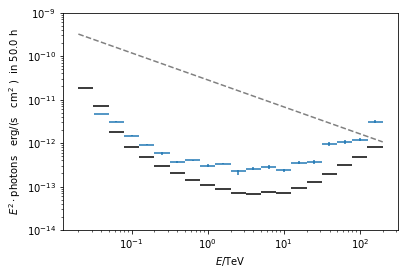

In [12]:
# rs = calc_relative_sensitivity(gammas, protons, bin_edges, alpha=0.1, optimize=True)
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# print('with electrons')
# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2,)
# plot_sensitivity(rs, crab, bin_edges, bin_center)

print('-------------')
print('only protons')
rs = calc_relative_sensitivity(signal, protons, bin_edges, alpha=0.2,)
plot_sensitivity(rs, crab, bin_edges, bin_center)


# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.02, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.03, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)

# # rs = calc_relative_sensitivity(signal, protons, bin_edges, alpha=0.2, theta2=0.03, )
# # plot_sensitivity(rs, crab, bin_edges, bin_center)
# # 

# rs = calc_relative_sensitivity(signal, background, bin_edges, alpha=0.2, theta2=0.04, )
# plot_sensitivity(rs, crab, bin_edges, bin_center)
# rs = calc_relative_sensitivity(gammas, protons, bin_edges, alpha=0.2, optimize=False)
# plot_sensitivity(rs, crab, bin_edges, bin_center)